In [43]:
import torch
from torch_geometric.loader import DataLoader
from data_creation import create_dataset, to_pyg_data_true
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import GAE
from torch.nn import BCEWithLogitsLoss
from torch_geometric.utils import negative_sampling
from torch.optim import Adam
import numpy as np
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

import os.path as osp

In [26]:
# load the Cora dataset
dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]
print(dataset.data)

# use train_test_split_edges to create neg and positive edges
data.train_mask = data.val_mask = data.test_mask = data.y = None
data = train_test_split_edges(data)
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Data(x=[2708, 1433], val_pos_edge_index=[2, 263], test_pos_edge_index=[2, 527], train_pos_edge_index=[2, 8976], train_neg_adj_mask=[2708, 2708], val_neg_edge_index=[2, 263], test_neg_edge_index=[2, 527])


c:\Users\Lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
c:\Users\Lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [49]:
# Generate just one huge graph
ode_dim = 100
n_data = 100
tp = torch.tensor(np.linspace(0,1,100))
x_exact, x_train, y_train, param = create_dataset(ode_dim,n_data,1,tp)
num_features = n_data*len(tp)

dataset_train = []
for i in range(0,len(x_train)):
    p = param[i]
    param_tensor = torch.cat((p.Win.flatten(),p.Wout.flatten(),p.bin.flatten(),p.bout.flatten(),p.gamma.flatten()))
    dataset_train.append(to_pyg_data_true(x_train[i],y_train[i],ode_dim,n_data*len(tp)))

data = dataset_train[0]

print(data.x.shape)

data = train_test_split_edges(data, val_ratio=0.1, test_ratio=0.1)

print(data)

torch.Size([100, 10000])
Data(x=[100, 10000], y=[10000], val_pos_edge_index=[2, 144], val_pos_edge_attr=[144], test_pos_edge_index=[2, 144], test_pos_edge_attr=[144], train_pos_edge_index=[2, 2316], train_pos_edge_attr=[2316], train_neg_adj_mask=[100, 100], val_neg_edge_index=[2, 144], test_neg_edge_index=[2, 144])


c:\Users\Lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [50]:
class Net(torch.nn.Module):
    def __init__(self,input_dim,hidden_dim=200):
        super(Net, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)

        self.lin1 = torch.nn.Linear(hidden_dim, hidden_dim).weight

        self.dropout = torch.nn.Dropout(p=0.7)

    def encode(self):
        x = self.conv1(data.x, data.train_pos_edge_index) # convolution 1
        x = F.leaky_relu(x)
        x = self.dropout(x)
        x = self.conv2(x, data.train_pos_edge_index) # convolution 2
        x = F.leaky_relu(x)
        x = self.dropout(x)
        return self.conv3(x, data.train_pos_edge_index) # convolution 3

    def decode(self, z, pos_edge_index, neg_edge_index): # only pos and neg edges
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1) # concatenate pos and neg edges
        logits = (z[edge_index[0]] * torch.matmul(self.lin1,z[edge_index[1]].t()).t()).sum(dim=-1)  # dot product with learnable parameter
        return logits

    def decode_all(self, z): 
        prob_adj = z @ z.t() # get adj NxN
        return (prob_adj > 0).nonzero(as_tuple=False).t() # get predicted edge_list 

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = Net(num_features).to(device), data.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [52]:

def get_link_labels(pos_edge_index, neg_edge_index):
    # returns a tensor:
    # [1,1,1,1,...,0,0,0,0,0,..] with the number of ones is equel to the length of pos_edge_index
    # and the number of zeros is equal to the length of neg_edge_index
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels


def train():
    model.train()

    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index, #positive edges
        num_nodes=data.num_nodes, # number of nodes
        num_neg_samples=data.train_pos_edge_index.size(1)) # number of neg_sample equal to number of pos_edges

    optimizer.zero_grad()
    
    z = model.encode() #encode
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index) # decode
    
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()

    return loss


@torch.no_grad()
def test():
    model.eval()
    perfs = []
    for prefix in ["val", "test"]:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']

        z = model.encode() # encode train
        link_logits = model.decode(z, pos_edge_index, neg_edge_index) # decode test or val
        link_probs = link_logits.sigmoid() # apply sigmoid

        link_labels = get_link_labels(pos_edge_index, neg_edge_index) # get link
        #print(link_probs[:len(pos_edge_index)].mean())
        #print(link_probs[len(pos_edge_index):].mean())
        perfs.append(roc_auc_score(link_labels.cpu(), link_probs.cpu())) #compute roc_auc score
    return perfs

In [53]:

best_val_perf = test_perf = 0
for epoch in range(1, 100000):
    train_loss = train()
    val_perf, tmp_test_perf = test()
    if val_perf > best_val_perf:
        best_val_perf = val_perf
        test_perf = tmp_test_perf
    log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, best_val_perf, test_perf))

Epoch: 010, Loss: 79064.8984, Val: 0.5000, Test: 0.5000
Epoch: 020, Loss: 43703.2188, Val: 0.5000, Test: 0.5000
Epoch: 030, Loss: 1854.6610, Val: 0.5000, Test: 0.5000
Epoch: 040, Loss: 2006.6151, Val: 0.5000, Test: 0.5000
Epoch: 050, Loss: 1359.0347, Val: 0.5000, Test: 0.5000
Epoch: 060, Loss: 987.5823, Val: 0.5000, Test: 0.5000
Epoch: 070, Loss: 347.6730, Val: 0.5018, Test: 0.5001
Epoch: 080, Loss: 386.6512, Val: 0.5050, Test: 0.5080
Epoch: 090, Loss: 382.1568, Val: 0.5050, Test: 0.5080
Epoch: 100, Loss: 261.9381, Val: 0.5050, Test: 0.5080
Epoch: 110, Loss: 321.5575, Val: 0.5050, Test: 0.5080
Epoch: 120, Loss: 138.0269, Val: 0.5050, Test: 0.5080
Epoch: 130, Loss: 96.8917, Val: 0.5050, Test: 0.5080
Epoch: 140, Loss: 299.4524, Val: 0.5050, Test: 0.5080
Epoch: 150, Loss: 190.9396, Val: 0.5050, Test: 0.5080
Epoch: 160, Loss: 101.0290, Val: 0.5050, Test: 0.5080
Epoch: 170, Loss: 83.4568, Val: 0.5050, Test: 0.5080
Epoch: 180, Loss: 101.6479, Val: 0.5050, Test: 0.5080
Epoch: 190, Loss: 100.8

KeyboardInterrupt: 

(100, 200)


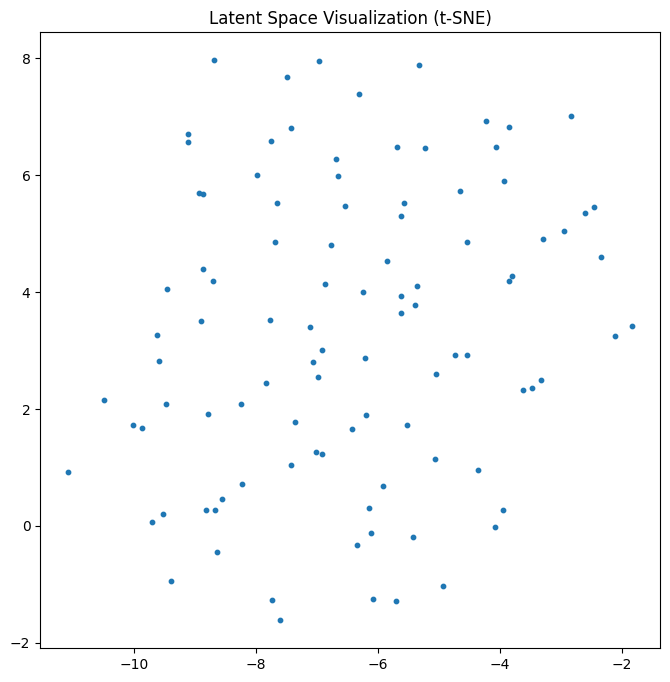

In [54]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

latent_embeddings =  torch.tensor(1)

z = model.encode()

with torch.no_grad():
    if len(latent_embeddings.shape) == 0:
            latent_embeddings = z
    else:
        latent_embeddings = torch.cat((latent_embeddings,z))

latent_embeddings = latent_embeddings.cpu().detach().numpy()
print(latent_embeddings.shape)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_embeddings = tsne.fit_transform(latent_embeddings)

plt.figure(figsize=(8, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=10)
plt.title("Latent Space Visualization (t-SNE)")
plt.show()